<a href="https://colab.research.google.com/github/YosukeSugiura/Edge_detection_using_GSP/blob/main/Edge_feature_extraction_using_Graph_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# グラフ信号処理を利用したエッジ特徴量抽出

---
信号処理技術により抽出された画像のエッジ情報には，ノイズや微細構造など，後段の処理において不要なテクスチャが現れる場合がある．

そこで，エッジ画素同士の繋がりをグラフで表し，グラフ信号における特徴量を調べることで，従来のエッジ抽出とは異なる特徴量の抽出を試みる．

In [157]:
!pip install pygsp

In [158]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from pygsp.reduction import *
from pygsp import plotting
from scipy.sparse import coo_matrix, lil_matrix, csr_matrix
import scipy.signal as sg
import skimage

In [159]:
print(skimage.__version__)

0.18.3


---
## 関数群



- canny : canny法によるエッジ抽出．

ただし，本Cannny法はエッジ画素値を画像の勾配値に置き換えている．したがって，エッジ画像は連続値で得られる．

In [160]:
import scipy.ndimage as ndi
from skimage._shared.utils import check_nD
from scipy.ndimage import generate_binary_structure, binary_erosion, label
from skimage.filters import gaussian
from skimage import dtype_limits, img_as_float

def canny(image, sigma=1., low_threshold=None, high_threshold=None,
          mask=None, use_quantiles=False, *, mode='constant', cval=0.0, keep_grad=False):

    def _preprocess(image, mask, sigma, mode, cval):
      gaussian_kwargs = dict(sigma=sigma, mode=mode, cval=cval,
                            preserve_range=False)
      if mask is None:
          # Smooth the masked image
          smoothed_image = gaussian(image, **gaussian_kwargs)
          eroded_mask = np.ones(image.shape, dtype=bool)
          eroded_mask[:1, :] = 0
          eroded_mask[-1:, :] = 0
          eroded_mask[:, :1] = 0
          eroded_mask[:, -1:] = 0
          return smoothed_image, eroded_mask

      masked_image = np.zeros_like(image)
      masked_image[mask] = image[mask]

      # Compute the fractional contribution of masked pixels by applying
      # the function to the mask (which gets you the fraction of the
      # pixel data that's due to significant points)
      bleed_over = (
          gaussian(mask.astype(float), **gaussian_kwargs) + np.finfo(float).eps
      )

      # Smooth the masked image
      smoothed_image = gaussian(masked_image, **gaussian_kwargs)

      # Lower the result by the bleed-over fraction, so you can
      # recalibrate by dividing by the function on the mask to recover
      # the effect of smoothing from just the significant pixels.
      smoothed_image /= bleed_over

      # Make the eroded mask. Setting the border value to zero will wipe
      # out the image edges for us.
      s = ndi.generate_binary_structure(2, 2)
      eroded_mask = ndi.binary_erosion(mask, s, border_value=0)

      return smoothed_image, eroded_mask

    def _set_local_maxima(magnitude, pts, w_num, w_denum, row_slices,
                      col_slices, out):
      r_0, r_1, r_2, r_3 = row_slices
      c_0, c_1, c_2, c_3 = col_slices
      c1 = magnitude[r_0, c_0][pts[r_1, c_1]]
      c2 = magnitude[r_2, c_2][pts[r_3, c_3]]
      m = magnitude[pts]
      w = w_num[pts] / w_denum[pts]
      c_plus = c2 * w + c1 * (1 - w) <= m
      c1 = magnitude[r_1, c_1][pts[r_0, c_0]]
      c2 = magnitude[r_3, c_3][pts[r_2, c_2]]
      c_minus = c2 * w + c1 * (1 - w) <= m
      out[pts] = c_plus & c_minus

      return out

    def _get_local_maxima(isobel, jsobel, magnitude, eroded_mask):
        abs_isobel = np.abs(isobel)
        abs_jsobel = np.abs(jsobel)

        eroded_mask = eroded_mask & (magnitude > 0)

        # Normals' orientations
        is_horizontal = eroded_mask & (abs_isobel >= abs_jsobel)
        is_vertical = eroded_mask & (abs_isobel <= abs_jsobel)
        is_up = (isobel >= 0)
        is_down = (isobel <= 0)
        is_right = (jsobel >= 0)
        is_left = (jsobel <= 0)
        #
        # --------- Find local maxima --------------
        #
        # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
        # 90-135 degrees and 135-180 degrees.
        #
        local_maxima = np.zeros(magnitude.shape, bool)
        # ----- 0 to 45 degrees ------
        # Mix diagonal and horizontal
        pts_plus = is_up & is_right
        pts_minus = is_down & is_left
        pts = ((pts_plus | pts_minus) & is_horizontal)
        # Get the magnitudes shifted left to make a matrix of the points to the
        # right of pts. Similarly, shift left and down to get the points to the
        # top right of pts.
        local_maxima = _set_local_maxima(
            magnitude, pts, abs_jsobel, abs_isobel,
            [slice(1, None), slice(-1), slice(1, None), slice(-1)],
            [slice(None), slice(None), slice(1, None), slice(-1)],
            local_maxima)
        # ----- 45 to 90 degrees ------
        # Mix diagonal and vertical
        #
        pts = ((pts_plus | pts_minus) & is_vertical)
        local_maxima = _set_local_maxima(
            magnitude, pts, abs_isobel, abs_jsobel,
            [slice(None), slice(None), slice(1, None), slice(-1)],
            [slice(1, None), slice(-1), slice(1, None), slice(-1)],
            local_maxima)
        # ----- 90 to 135 degrees ------
        # Mix anti-diagonal and vertical
        #
        pts_plus = is_down & is_right
        pts_minus = is_up & is_left
        pts = ((pts_plus | pts_minus) & is_vertical)
        local_maxima = _set_local_maxima(
            magnitude, pts, abs_isobel, abs_jsobel,
            [slice(None), slice(None), slice(-1), slice(1, None)],
            [slice(1, None), slice(-1), slice(1, None), slice(-1)],
            local_maxima)
        # ----- 135 to 180 degrees ------
        # Mix anti-diagonal and anti-horizontal
        #
        pts = ((pts_plus | pts_minus) & is_horizontal)
        local_maxima = _set_local_maxima(
            magnitude, pts, abs_jsobel, abs_isobel,
            [slice(-1), slice(1, None), slice(-1), slice(1, None)],
            [slice(None), slice(None), slice(1, None), slice(-1)],
            local_maxima)

        return local_maxima

    check_nD(image, 2)
    dtype_max = dtype_limits(image, clip_negative=False)[1]

    if low_threshold is None:
        low_threshold = 0.1
    elif use_quantiles:
        if not(0.0 <= low_threshold <= 1.0):
            raise ValueError("Quantile thresholds must be between 0 and 1.")
    else:
        low_threshold /= dtype_max

    if high_threshold is None:
        high_threshold = 0.2
    elif use_quantiles:
        if not(0.0 <= high_threshold <= 1.0):
            raise ValueError("Quantile thresholds must be between 0 and 1.")
    else:
        high_threshold /= dtype_max

    if high_threshold < low_threshold:
        raise ValueError("low_threshold should be lower then high_threshold")

    # Image filtering
    smoothed, eroded_mask = _preprocess(image, mask, sigma, mode, cval)

    # Gradient magnitude estimation
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    magnitude = np.hypot(isobel, jsobel)

    if use_quantiles:
        low_threshold, high_threshold = np.percentile(magnitude,
                                                      [100.0 * low_threshold,
                                                       100.0 * high_threshold])

    # Non-maximum suppression
    local_maxima = _get_local_maxima(isobel, jsobel, magnitude, eroded_mask)

    # Double thresholding and edge traking
    low_mask = local_maxima & (magnitude >= low_threshold)

    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = ndi.label(low_mask, strel)
    if count == 0:
        return low_mask

    high_mask = local_maxima & (magnitude >= high_threshold)
    nonzero_sums = np.unique(labels[high_mask])
    good_label = np.zeros((count + 1,), bool)
    good_label[nonzero_sums] = True
    output_mask = good_label[labels]
    magnitude[output_mask==0] = 0
    output = magnitude if keep_grad else output_mask
    return output


- `img_to_graph` : エッジ画像をグラフに変換する．

In [161]:
def img_to_graph(edge, vertex=True):

    index_image = np.zeros(edge.shape)
    x, y = np.nonzero(edge)     # 非ゼロ要素インデクス
    N = np.count_nonzero(edge)  # 非ゼロ要素数
    V = edge[x, y]              # 頂点信号

    # エッジピクセルにインデックスを降ったもの
    index_image[x,y] = np.arange(1,N+1)

    # ゼロパディング
    index_image = np.pad(index_image, 1)

    # 周囲8ピクセルを注目してエッジのインデックス検出
    # - 周囲を取り出すマスク
    ix,iy = np.meshgrid(np.arange(-1,2),np.arange(-1,2))
    ix, iy = ix.ravel(), iy.ravel()
    ix, iy = np.delete(ix, 4), np.delete(iy, 4)   # 中央抜き

    x, y = np.nonzero(index_image)
    row_ = []
    column_ = []
    for ind, (x_, y_) in enumerate(zip(x,y)):
        edge_index = index_image[x_+ix, y_+iy].flatten().astype(int) # 隣接するエッジのインデックスを抽出
        edge_ = edge_index[np.nonzero(edge_index)]-1 # ゼロを除去
        row_.extend(edge_)                           # エッジインデックス-x
        column_.extend(ind*np.ones(edge_.shape, dtype=int))# エッジインデックス-y

    row_ = np.array(row_).flatten()
    column_ = np.array(column_).flatten()
    A = coo_matrix((np.ones(len(row_)), (row_, column_)), shape=(N, N)).toarray()

    if vertex:
        return A, V
    else:
        return A

-` img_to_graph` : グラフをエッジ画像に変換する．

In [162]:
def graph_to_img(vertex, image_shape, mask=None):
    pixel_seq = vertex
    if mask is None:
        img =  pixel_seq.reshape(image_shape)
    else:
        img = np.zeros(mask.shape)
        img[mask] = pixel_seq
    return img

- `plot_coo_matrix` : coo_matrixを表示する．

In [163]:
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

- `plt_gft_basis` : グラフフーリエ変換したグラフの基底を表示する．

In [164]:
def plt_gft_basis(U, img, idx=[0], mask=None):

    img_cpy = img.copy()
    mask = np.ones(img.shape, dtype=bool) if mask is None else mask

    cnt = 10
    for id in idx:
        u = U[:,id]
        img_cpy[mask] = np.sign(u) * np.abs(u)**(0.5)
        abs_max = np.max(np.abs(u))

        fig = plt.figure(figsize=(3,3))
        plt.title('GFT Basis: '+ str(id), y=-0.18)
        plt.imshow(img_cpy, cmap='seismic',vmin=-abs_max, vmax=abs_max)
        plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        cnt += 1

---
# メイン関数

はじめにMatplotlibの設定を行う．

In [165]:
# Settings
plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

画像を読み込み，改良Canny法によりエッジ画像を得る．

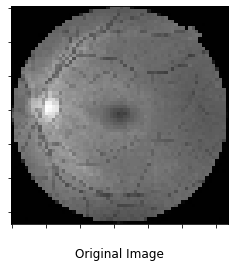

In [166]:
    # -------------------------------------
    #   画像読み込み & エッジ抽出
    # -------------------------------------

    # データ読み込み
    retina_source = data.retina()

    # 圧縮
    img = cv2.resize(retina_source, dsize=(64,64))
    # グレースケール変換
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(4,4))
    plt.title('Original Image', y=-0.18)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)


    # Canny法によるエッジ抽出
    Thr_max = 0.3       # エッジ検出最大しきい値
    Thr_min = 0.05      # エッジ検出最小しきい値
    img_edge = canny(img, 1, Thr_min, Thr_max, keep_grad=True)
    img_edge = img_edge/255 # 最大1で正規化

    # 形状・マスク情報取得
    img_shape = img_edge.shape
    mask = img_edge.astype(bool)

エッジ画像からグラフに変換する．

In [167]:
    # -------------------------------------
    #   画像→グラフ 変換
    # -------------------------------------

    # エッジ画像 -> 隣接行列 (とvertex)
    A, vertex = img_to_graph(img_edge, vertex=True)
    # - グラフ行列 -> 画像の変換をしたいなら以下の通り
    #img_rec = graph_to_img(vertex, img_shape, mask=mask)

    # 隣接行列 -> グラフオブジェクト
    graph_obj = graphs.Graph(A)
    N = graph_obj.N                 # 基底の次元数

グラフからグラフフーリエ基底を計算する．

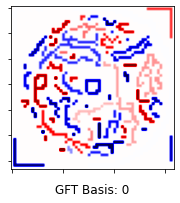

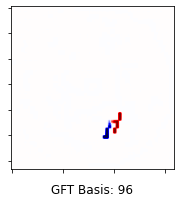

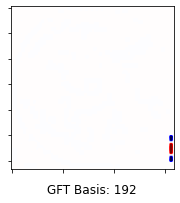

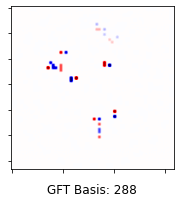

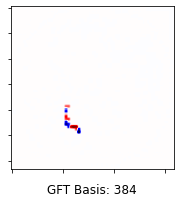

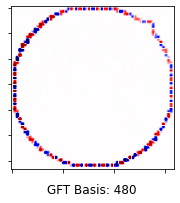

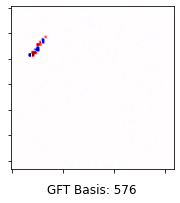

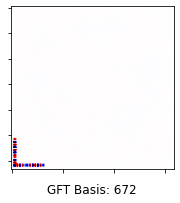

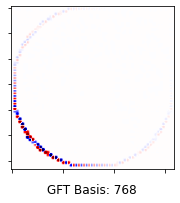

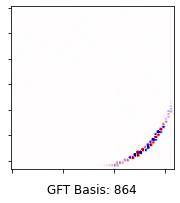

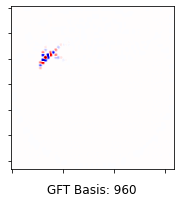

In [168]:
    # -------------------------------------
    #   グラフフーリエ変換に向けた準備
    # -------------------------------------
    # グラフフーリエ基底の計算
    graph_obj.compute_fourier_basis()

    # 基底の図示
    num_of_figure = 10 # 図の個数
    plt_gft_basis(graph_obj.U,img_edge,
                  idx=list(np.arange(0,N,N//num_of_figure)), mask=mask)
    # vertex(頂点グラフ信号)
    d = vertex

    # 変形
    D = len(d)
    N = graph_obj.N
    L = -(-D//N)
    d.resize(N,L,refcheck=False)

計算したグラフフーリエ基底を利用して，グラフフーリエ変換を行う．

In [169]:
    # -------------------------------------
    #   グラフフーリエ変換
    # -------------------------------------
    # グラフフーリエ変換
    W_gft = graph_obj.gft(d)
    d_ = graph_obj.igft(W_gft)
    print('Error of Reconstruction (GFT->IGFT) : ',np.sum(np.abs(d - d_)))

Error of Reconstruction (GFT->IGFT) :  1.3349815231131906e-15


グラフフーリエ領域でフィルタリングを行う．
まず，様々なフィルタを用意する．

In [170]:
    # -------------------------------------
    #   フィルタ設定 (周波数領域フィルタとスパース化フィルタ)
    # -------------------------------------
    # a. グラフ周波数領域フィルタの設定
    ind_lin = np.linspace(0,1,graph_obj.N)
    Flt1 = (ind_lin < 0.01)       # ステップ関数 (低域通過フィルタ)
    _, Flt2 = np.abs(sg.freqz(np.ones(21)/21,1,graph_obj.N)) # FIRフィルター (低域通過フィルタ)
    _, Flt3 = np.abs(sg.freqz(1-0.99,np.array([1, 0.99]),graph_obj.N)) # IIRフィルター (高域通過フィルタ)
    Flt = [Flt1[:,np.newaxis], Flt2[:,np.newaxis], Flt3[:,np.newaxis]]

    # b. 係数の絶対値の小さいものを消すフィルタ
    # - 係数の絶対値の小さい順に並べる
    id_sort = np.argsort(np.abs(W_gft.flatten()))
    # - フィルタ設定
    Flt4 = np.ones(W_gft.size)
    Fc = round(len(id_sort)*0.995)
    Flt4[id_sort[:Fc]] = 0
    Flt4 = Flt4.reshape(W_gft.shape)

    Flt.append(Flt4)

グラフ周波数領域成分をフィルタリングする．
その後，IGFTを行いグラフに変換する．

In [171]:
    # -------------------------------------
    #   フィルタリング→IGFT
    # -------------------------------------
    # フィルタリング + 逆GFT
    W_flt_list = []
    d_tr_list = []
    # - グラフ周波数フィルタリング
    for flt in Flt:
        w_flt = flt * W_gft             # フィルタリング
        d_tr = graph_obj.igft(w_flt)    # 逆グラフフーリエ変換
        # 元の形に変形
        d_tr = np.reshape(d_tr, [N * L, ])[:D]
        d_tr[d_tr<0]=0
        # 保存
        W_flt_list.append(w_flt)
        d_tr_list.append(d_tr)

グラフからエッジ画像を復元する．

In [172]:
    # -------------------------------------
    #   グラフ→画像 変換
    # -------------------------------------
    img_rec_list = []
    for d_tr in d_tr_list:

        # グラフ→画像
        img_rec = graph_to_img(d_tr, img_shape, mask=mask)
        img_rec_list.append(img_rec)

図示する．

Text(0.5, 0, 'Index of basis')

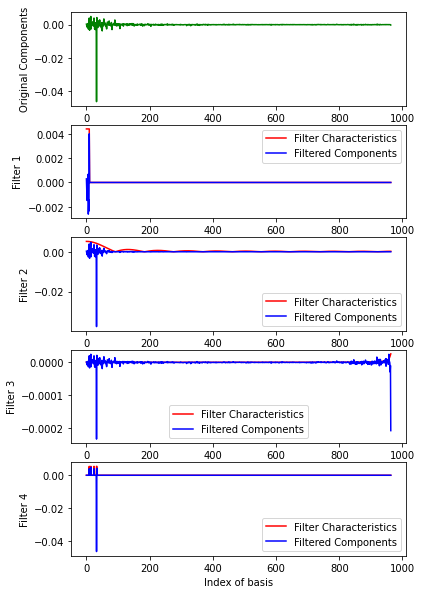

In [174]:
    # -------------------------------------
    #   図示 - グラフ周波数成分
    # -------------------------------------
    # グラフ周波数成分の図示
    fig = plt.figure(figsize=(6, 10))
    L = len(W_flt_list) + 1
    ax = fig.add_subplot(L, 1, 1)
    ax.plot(np.mean(W_gft, axis=-1), 'g')
    ax.set_ylabel('Original Components')
    for i, (w_flt, flt) in enumerate(zip(W_flt_list, Flt)):
        if flt.ndim > 1:
            flt = np.mean(flt, axis=-1)
        ax = fig.add_subplot(L, 1, i + 2)
        ax.plot(flt * np.max(w_flt) * 1.1, 'r', label='Filter Characteristics')
        ax.plot(np.mean(w_flt, axis=-1), 'b', label='Filtered Components')
        ax.set_ylabel('Filter ' + str(i + 1))
        ax.legend()
    ax.set_xlabel('Index of basis')

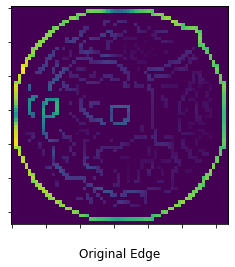

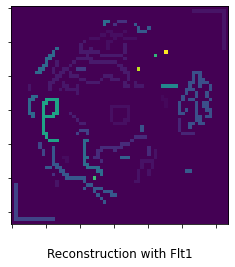

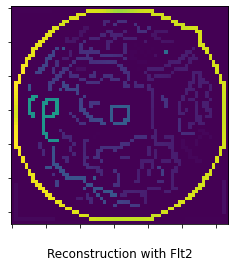

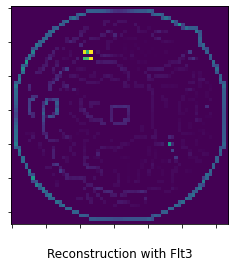

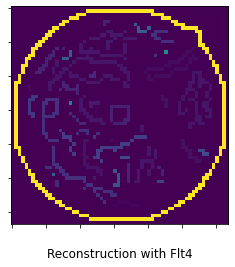

In [175]:
    # -------------------------------------
    #   図示 - 復元画像の図示
    # -------------------------------------
    # 復元画像の図示
    plt.figure('Original Edge', figsize=(4,4))
    plt.title('Original Edge', y=-0.18) 
    plt.imshow(img_edge)
    plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    for k, img_ in enumerate(img_rec_list):
        plt.figure(figsize=(4,4))
        plt.title('Reconstruction with Flt'+ str(k+1), y=-0.18) 
        plt.imshow(img_)
        plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    plt.show()